In [122]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [140]:
train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')

products_description = pd.read_csv('./data/product_descriptions.csv')

In [149]:
# merge with product description

train = pd.merge(train, products_description, how='left', on='product_uid')
test = pd.merge(test, products_description, how='left', on='product_uid')

In [150]:
train.head()

,product_uid,product_title,search_term,relevance,product_description
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


In [151]:
test.head()

,product_uid,product_title,search_term,product_description
0,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ..."
1,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ..."
2,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ..."
3,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ..."
4,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ..."


In [152]:
y = train.relevance

In [153]:
from sklearn.cross_validation import train_test_split

In [154]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=44)

In [155]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(51846, 5) (22221, 5) (51846L,) (22221L,)


In [156]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PassiveAggressiveRegressor, SGDRegressor

from sklearn.preprocessing import MinMaxScaler

In [164]:
%run scripts/features.py

In [165]:
ft = FeatureTransformer()
scaler = MinMaxScaler()
clf = PassiveAggressiveRegressor(C=0.01)
# clf = SGDRegressor(penalty='l1')

online_model_pipe = Pipeline([('ft', ft), ('scaler', scaler), ('clf', clf)])

online_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ft', FeatureTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', PassiveAggressiveRegressor(C=0.01, class_weight=None, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', n_iter=5,
              random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [166]:
from sklearn.metrics import mean_squared_error

In [ ]:
predsTrain = online_model_pipe.predict(X_train)
predsTest = online_model_pipe.predict(X_test)

In [161]:
print 'RMSE on the training set %f ' %(np.sqrt(mean_squared_error(y_train, predsTrain)))
print 'RMSE on the test set %f ' %(np.sqrt(mean_squared_error(y_test, predsTest)))

RMSE on the training set 0.547219 
RMSE on the test set 0.546648 


In [116]:
# fit on the entire training dataset
online_model_pipe.fit(train, y)

Pipeline(steps=[('ft', FeatureTransformer()), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [117]:
predictions = online_model_pipe.predict(test)

In [118]:
def scale_predictions(prediction):
    if prediction > 3.0:
        return 3.0
    elif prediction < 1.0:
        return 1.0
    else:
        return prediction

In [119]:
predictions = map(scale_predictions, predictions)

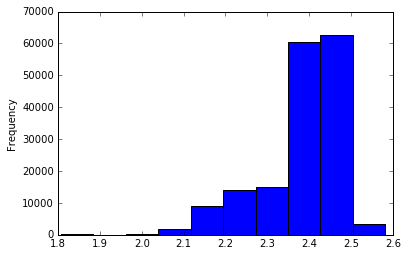

In [120]:
pd.Series(predictions).plot(kind='hist')

In [121]:
# prepare submission file
submission = pd.read_csv('./data/sample_submission.csv')
submission['relevance'] = predictions
submission.to_csv('./submissions/fourth.csv', index=False)